Combining LaTeX files...
Processing /home/hp/results/MOUSE/level0/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level1/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level2/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level3/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level4/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level5/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level6/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level7/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level8/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level9/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level10/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level11/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level12/combined_latex_table.tex...
Processing /home/hp/results/MOUSE/level13/combined_latex_table.tex...
Proce

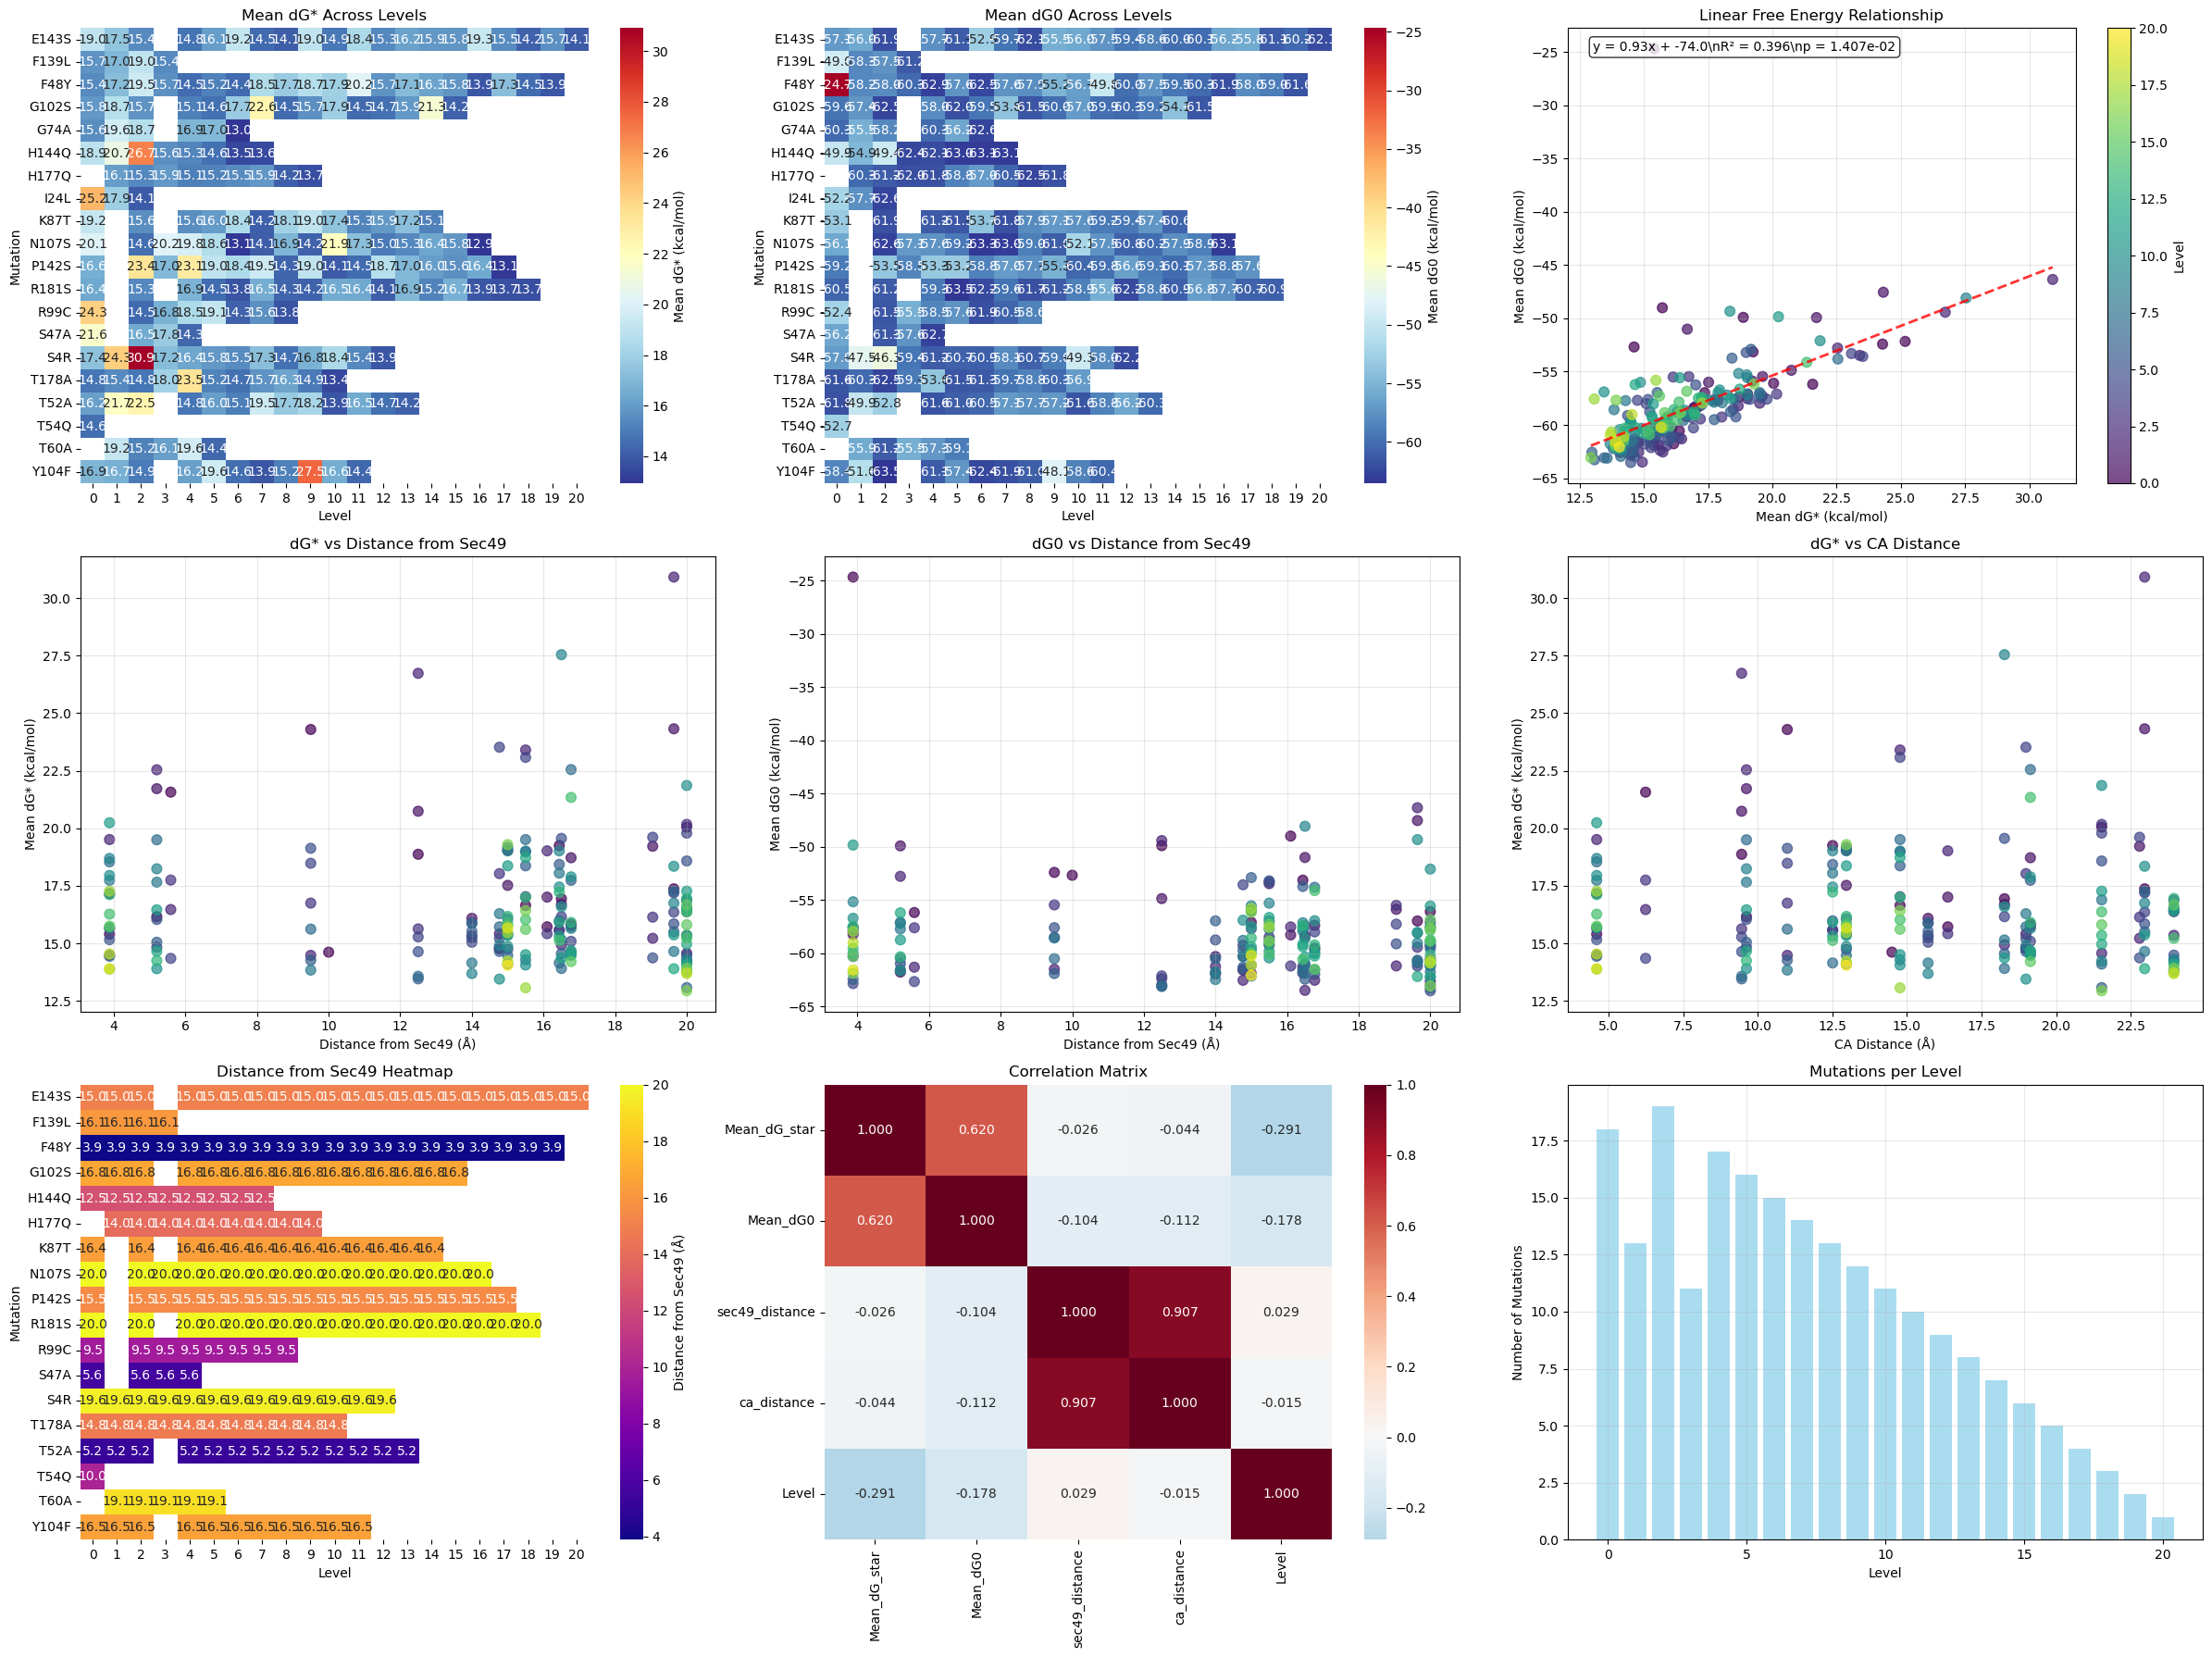

In [6]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def linear_regression(x, y):
    """Simple linear regression using numpy"""
    x = np.array(x)
    y = np.array(y)
    
    # Remove NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    if len(x) < 2:
        return None, None, None, None, None
    
    # Calculate slope and intercept
    slope = np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.sum((x - np.mean(x))**2)
    intercept = np.mean(y) - slope * np.mean(x)
    
    # Calculate R-squared
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # Calculate correlation coefficient
    r_value = np.sqrt(r_squared) if slope > 0 else -np.sqrt(r_squared)
    
    # Simple p-value approximation (not exact but useful)
    n = len(x)
    t_stat = r_value * np.sqrt((n-2)/(1-r_squared)) if r_squared < 1 else 0
    p_value = 2 * (1 - 0.5 * (1 + np.sign(t_stat) * np.sqrt(1 - 1/(1 + t_stat**2/4))))
    
    return slope, intercept, r_value, p_value, None

def get_distance_data():
    """Get distance data for mutations"""
    mutants = [
        {"name": "C49U", "sec49_distance": 0.0, "ca_distance": 5.47, "dg_star": 14.84, "dg0": -62.60},
        {"name": "F48Y", "sec49_distance": 3.88, "ca_distance": 4.60, "dg_star": 17.38, "dg0": -55.26},
        {"name": "T52A", "sec49_distance": 5.20, "ca_distance": 9.62, "dg_star": 16.16, "dg0": -61.77},
        {"name": "S47A", "sec49_distance": 5.59, "ca_distance": 6.24, "dg_star": 21.57, "dg0": -56.18},
        {"name": "R99C", "sec49_distance": 9.50, "ca_distance": 10.99, "dg_star": 24.29, "dg0": -55.41},
        {"name": "T54Q", "sec49_distance": 10.00, "ca_distance": 14.50, "dg_star": 14.62, "dg0": -55.68},
        {"name": "H177Q", "sec49_distance": 14.00, "ca_distance": 15.71, "dg_star": 18.66, "dg0": -55.40},
        {"name": "H144Q", "sec49_distance": 12.50, "ca_distance": 9.46, "dg_star": 17.66, "dg0": -53.40},
        {"name": "T178A", "sec49_distance": 14.77, "ca_distance": 18.99, "dg_star": 14.77, "dg0": -61.57},
        {"name": "A74G", "sec49_distance": 14.29, "ca_distance": 21.53, "dg_star": 15.06, "dg0": -60.08},
        {"name": "E143S", "sec49_distance": 15.00, "ca_distance": 12.97, "dg_star": 19.04, "dg0": -57.10},
        {"name": "F139L", "sec49_distance": 16.10, "ca_distance": 16.37, "dg_star": 15.72, "dg0": -54.00},
        {"name": "K87T", "sec49_distance": 16.44, "ca_distance": 12.51, "dg_star": 18.21, "dg0": -53.05},
        {"name": "P142S", "sec49_distance": 15.50, "ca_distance": 14.77, "dg_star": 16.30, "dg0": -59.56},
        {"name": "G102S", "sec49_distance": 16.77, "ca_distance": 19.14, "dg_star": 15.83, "dg0": -59.61},
        {"name": "Y104F", "sec49_distance": 16.50, "ca_distance": 18.27, "dg_star": 16.94, "dg0": -58.41},
        {"name": "L24I", "sec49_distance": 17.00, "ca_distance": 19.20, "dg_star": 15.68, "dg0": -60.30},
        {"name": "T60A", "sec49_distance": 19.05, "ca_distance": 22.80, "dg_star": 18.09, "dg0": -58.09},
        {"name": "R181S", "sec49_distance": 20.00, "ca_distance": 23.95, "dg_star": 16.38, "dg0": -60.55},
        {"name": "S4R", "sec49_distance": 19.64, "ca_distance": 22.97, "dg_star": 17.37, "dg0": -56.97},
        {"name": "N107S", "sec49_distance": 20.00, "ca_distance": 21.53, "dg_star": 20.05, "dg0": -56.09},
    ]
    
    # Convert to DataFrame and normalize mutation names for matching
    distance_df = pd.DataFrame(mutants)
    distance_df['mutation_normalized'] = distance_df['name'].str.replace('U', 'A')  # Handle C49U -> C49A case
    return distance_df

def extract_data_from_latex(latex_content):
    """Extract mutation data from LaTeX table content"""
    data = []
    
    # Find all mutation entries using regex
    # Look for patterns like "G74A & 15.59 \\pm 0.94 kcal/mol & -60.29 \\pm 1.09 kcal/mol"
    pattern = r'([A-Z]\d+[A-Z]) & ([^&]+) & ([^\\]+)'
    matches = re.findall(pattern, latex_content)
    
    for match in matches:
        mutation = match[0]
        dg_star = match[1].strip()
        dg0 = match[2].strip()
        
        # Extract numeric values (handle nan cases)
        try:
            dg_star_val = float(re.search(r'([\d.-]+|nan)', dg_star).group(1))
            dg0_val = float(re.search(r'([\d.-]+|nan)', dg0).group(1))
        except:
            dg_star_val = np.nan
            dg0_val = np.nan
        
        data.append({
            'Mutation': mutation,
            'Mean_dG_star': dg_star_val,
            'Mean_dG0': dg0_val,
            'dG_star_raw': dg_star,
            'dG0_raw': dg0
        })
    
    return data

def combine_latex_files():
    """Combine all LaTeX files from level folders"""
    # Base path where all level folders are located
    base_path = '/home/hp/results/MOUSE'
    
    # Define level folders (including level1)
    level_folders = [
        'level0', 'level1', 'level2', 'level3', 'level4', 'level5', 'level6', 'level7', 
        'level8', 'level9', 'level10', 'level11', 'level12', 'level13', 
        'level14', 'level15', 'level16', 'level17', 'level18', 'level19', 'level20'
    ]
    
    all_data = []
    combined_latex = []
    
    # LaTeX header
    latex_header = """\\documentclass{article}
\\usepackage{booktabs}
\\usepackage{longtable}
\\begin{document}
\\begin{longtable}{|c|c|c|c|}
\\hline
Level & Mutation & Mean dG* & Mean dG0 \\\\
\\hline
\\endhead
"""
    
    combined_latex.append(latex_header)
    
    for folder in level_folders:
        file_path = os.path.join(base_path, folder, 'combined_latex_table.tex')
        
        if os.path.exists(file_path):
            print(f"Processing {file_path}...")
            
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                
                # Extract data
                data = extract_data_from_latex(content)
                
                # Add level information
                level_num = re.search(r'level(\d+)', folder).group(1)
                for item in data:
                    item['Level'] = int(level_num)
                    all_data.append(item)
                
                # Add to combined LaTeX
                for item in data:
                    if not (np.isnan(item['Mean_dG_star']) or np.isnan(item['Mean_dG0'])):
                        combined_latex.append(f"{level_num} & {item['Mutation']} & {item['dG_star_raw']} & {item['dG0_raw']} \\\\")
                        combined_latex.append("\\hline")
                
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")
    
    # LaTeX footer
    latex_footer = """\\end{longtable}
\\caption{Combined Free Energy Changes Across All Levels}
\\end{document}"""
    
    combined_latex.append(latex_footer)
    
    return all_data, '\n'.join(combined_latex)

def create_comprehensive_analysis(data):
    """Create comprehensive analysis including heatmaps, LFER plots, and distance analysis"""
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Get distance data
    distance_df = get_distance_data()
    
    # Merge with distance data
    df_merged = df.merge(
        distance_df[['name', 'sec49_distance', 'ca_distance']], 
        left_on='Mutation', 
        right_on='name', 
        how='left'
    )
    
    # Remove rows with NaN values for main analysis
    df_clean = df_merged.dropna(subset=['Mean_dG_star', 'Mean_dG0'])
    
    if df_clean.empty:
        print("No valid data found for analysis")
        return None
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(24, 18))
    
    # 1. Heatmaps for dG* and dG0 by level and mutation
    ax1 = plt.subplot(3, 3, 1)
    pivot_dg_star = df_clean.pivot_table(
        index='Mutation', columns='Level', values='Mean_dG_star', fill_value=np.nan
    )
    sns.heatmap(pivot_dg_star, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=ax1,
                cbar_kws={'label': 'Mean dG* (kcal/mol)'})
    ax1.set_title('Mean dG* Across Levels')
    
    ax2 = plt.subplot(3, 3, 2)
    pivot_dg0 = df_clean.pivot_table(
        index='Mutation', columns='Level', values='Mean_dG0', fill_value=np.nan
    )
    sns.heatmap(pivot_dg0, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=ax2,
                cbar_kws={'label': 'Mean dG0 (kcal/mol)'})
    ax2.set_title('Mean dG0 Across Levels')
    
    # 2. LFER Plot: dG* vs dG0
    ax3 = plt.subplot(3, 3, 3)
    df_lfer = df_clean.dropna(subset=['Mean_dG_star', 'Mean_dG0'])
    
    if len(df_lfer) > 1:
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linear_regression(df_lfer['Mean_dG_star'], df_lfer['Mean_dG0'])
        
        # Create scatter plot
        scatter = ax3.scatter(df_lfer['Mean_dG_star'], df_lfer['Mean_dG0'], 
                             c=df_lfer['Level'], cmap='viridis', s=60, alpha=0.7)
        
        # Add regression line
        x_line = np.linspace(df_lfer['Mean_dG_star'].min(), df_lfer['Mean_dG_star'].max(), 100)
        y_line = slope * x_line + intercept
        ax3.plot(x_line, y_line, 'r--', alpha=0.8, linewidth=2)
        
        # Add equation and R²
        ax3.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.1f}\\nR² = {r_value**2:.3f}\\np = {p_value:.3e}', 
                transform=ax3.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.colorbar(scatter, ax=ax3, label='Level')
    
    ax3.set_xlabel('Mean dG* (kcal/mol)')
    ax3.set_ylabel('Mean dG0 (kcal/mol)')
    ax3.set_title('Linear Free Energy Relationship')
    ax3.grid(True, alpha=0.3)
    
    # 3. Distance analysis plots
    df_dist = df_clean.dropna(subset=['sec49_distance', 'ca_distance'])
    
    if len(df_dist) > 0:
        # dG* vs sec49_distance
        ax4 = plt.subplot(3, 3, 4)
        scatter4 = ax4.scatter(df_dist['sec49_distance'], df_dist['Mean_dG_star'], 
                              c=df_dist['Level'], cmap='viridis', s=60, alpha=0.7)
        ax4.set_xlabel('Distance from Sec49 (Å)')
        ax4.set_ylabel('Mean dG* (kcal/mol)')
        ax4.set_title('dG* vs Distance from Sec49')
        ax4.grid(True, alpha=0.3)
        
        # dG0 vs sec49_distance
        ax5 = plt.subplot(3, 3, 5)
        ax5.scatter(df_dist['sec49_distance'], df_dist['Mean_dG0'], 
                   c=df_dist['Level'], cmap='viridis', s=60, alpha=0.7)
        ax5.set_xlabel('Distance from Sec49 (Å)')
        ax5.set_ylabel('Mean dG0 (kcal/mol)')
        ax5.set_title('dG0 vs Distance from Sec49')
        ax5.grid(True, alpha=0.3)
        
        # dG* vs ca_distance
        ax6 = plt.subplot(3, 3, 6)
        ax6.scatter(df_dist['ca_distance'], df_dist['Mean_dG_star'], 
                   c=df_dist['Level'], cmap='viridis', s=60, alpha=0.7)
        ax6.set_xlabel('CA Distance (Å)')
        ax6.set_ylabel('Mean dG* (kcal/mol)')
        ax6.set_title('dG* vs CA Distance')
        ax6.grid(True, alpha=0.3)
        
        # Distance heatmap
        ax7 = plt.subplot(3, 3, 7)
        dist_pivot = df_dist.pivot_table(
            index='Mutation', columns='Level', values='sec49_distance', fill_value=np.nan
        )
        sns.heatmap(dist_pivot, annot=True, fmt='.1f', cmap='plasma', ax=ax7,
                    cbar_kws={'label': 'Distance from Sec49 (Å)'})
        ax7.set_title('Distance from Sec49 Heatmap')
        
        # Correlation analysis
        ax8 = plt.subplot(3, 3, 8)
        corr_data = df_dist[['Mean_dG_star', 'Mean_dG0', 'sec49_distance', 'ca_distance', 'Level']]
        corr_matrix = corr_data.corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0, ax=ax8)
        ax8.set_title('Correlation Matrix')
        
        # Level distribution
        ax9 = plt.subplot(3, 3, 9)
        level_counts = df_clean['Level'].value_counts().sort_index()
        ax9.bar(level_counts.index, level_counts.values, alpha=0.7, color='skyblue')
        ax9.set_xlabel('Level')
        ax9.set_ylabel('Number of Mutations')
        ax9.set_title('Mutations per Level')
        ax9.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return fig, df_clean, df_dist

def main():
    """Main function to combine files and generate heatmap"""
    # Create output directory (files will be saved in the same base directory)
    output_dir = '/home/hp/results/MOUSE'
    
    print("Combining LaTeX files...")
    all_data, combined_latex = combine_latex_files()
    
    # Save combined LaTeX file
    output_latex_path = os.path.join(output_dir, 'combined_all_levels.tex')
    with open(output_latex_path, 'w', encoding='utf-8') as f:
        f.write(combined_latex)
    
    print(f"Combined LaTeX saved to: {output_latex_path}")
    
    # Create and save comprehensive analysis
    print("Generating comprehensive analysis...")
    result = create_comprehensive_analysis(all_data)
    
    if result is not None:
        fig, df_clean, df_dist = result
        
        # Save comprehensive analysis plot
        analysis_path = os.path.join(output_dir, 'comprehensive_analysis.png')
        fig.savefig(analysis_path, dpi=300, bbox_inches='tight')
        print(f"Comprehensive analysis saved to: {analysis_path}")
        
        # Save data as CSV for reference
        csv_path = os.path.join(output_dir, 'combined_data.csv')
        df_clean.to_csv(csv_path, index=False)
        print(f"Data saved to: {csv_path}")
        
        # Save distance analysis data
        if len(df_dist) > 0:
            dist_csv_path = os.path.join(output_dir, 'distance_analysis_data.csv')
            df_dist.to_csv(dist_csv_path, index=False)
            print(f"Distance analysis data saved to: {dist_csv_path}")
        
        # Display summary statistics
        print("\nSummary Statistics:")
        print(f"Total mutations processed: {len(df_clean)}")
        print(f"Levels covered: {sorted(df_clean['Level'].unique())}")
        print(f"Unique mutations: {len(df_clean['Mutation'].unique())}")
        print(f"Mutations with distance data: {len(df_dist)}")
        
        # LFER analysis summary
        df_lfer = df_clean.dropna(subset=['Mean_dG_star', 'Mean_dG0'])
        if len(df_lfer) > 1:
            slope, intercept, r_value, p_value, std_err = linear_regression(df_lfer['Mean_dG_star'], df_lfer['Mean_dG0'])
            print(f"\nLinear Free Energy Relationship:")
            print(f"Equation: dG0 = {slope:.3f} × dG* + {intercept:.2f}")
            print(f"R² = {r_value**2:.3f}")
            print(f"p-value = {p_value:.3e}")
        
        plt.show()
    else:
        print("No analysis generated due to insufficient data")

if __name__ == "__main__":
    main()